# Plotting model performance on data with more layers

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import analysis_folded as a
import Models
import FeatureExtract as FE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

### for now used eval dataset produced from old pickle files and added new ones with more layers

In [13]:
_, _, model_lr = Models.Linear_Reg()
_, _, model_lri = Models.Lin_Reg_Interaction()
_, _, model_rf = Models.Random_Forest()
_, _, model_rf_hyper = Models.Random_Forest_hyperparam()
_, _, model_rf_scaled = Models.Random_Forest_scaled()

135
Fitting 3 folds for each of 75 candidates, totalling 225 fits
{'n_estimators': 85, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 7, 'criterion': 'absolute_error', 'bootstrap': True}


In [14]:
training_feature_names = Models.df_train.columns
training_feature_names_scaled = Models.df_train_scaled.columns

#_, old_pickle_files = Models.split_data()
_, new_pickle_files = Models.split_data(path='./extrapolation', train_frac=0) # path to pickle files with different num_layers
y_eval_ipol = Models.df_eval    # is df

l = list()
for i, idx in enumerate(new_pickle_files):
    l.append(FE.extract_features(f"./extrapolation/{idx}"))
df = pd.DataFrame(l)

y_eval_ipol = pd.concat([y_eval_ipol, df])
display(y_eval_ipol)


#### calculate predictions on new dataset
poly = PolynomialFeatures(degree=2, interaction_only=False,include_bias = False)

y_ipol_pred_lr = model_lr.predict(y_eval_ipol[training_feature_names].drop(columns='target'))
y_ipol_pred_rf = model_rf.predict(y_eval_ipol[training_feature_names].drop(columns='target'))
y_ipol_pred_lri = model_lri.predict(poly.fit_transform(y_eval_ipol[training_feature_names].drop(columns='target')))
y_ipol_pred_rf_hyper = model_rf_hyper.predict(y_eval_ipol[training_feature_names].drop(columns='target'))
y_ipol_pred_rf_scaled = model_rf_scaled.predict(y_eval_ipol[training_feature_names_scaled].drop(columns='target'))

,noisy_expectation,num_layers,tot_num_gates,num_cx_gates,num_sx_gates,num_2_qubit_gates,obs_dummy_1,obs_dummy_2,obs_dummy_3,obs_dummy_4,obs_dummy_5,"count_['1', '2']","count_['1', '3']","count_['0', '1']","count_['3', '4']",target
0,-0.00922,5,208,40,56,40,1,0,0,0,0,10,10,10,10,0.346332
1,0.12596,4,168,32,45,32,0,0,1,0,0,8,8,8,8,-0.223024
2,0.05936,5,205,40,55,40,0,0,0,1,0,10,10,10,10,0.227908
3,-0.02128,1,59,8,16,8,0,1,0,0,0,2,2,2,2,0.084893
4,0.07196,3,134,24,36,24,0,0,1,0,0,6,6,6,6,-0.273271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.05122,7,279,56,75,56,1,0,0,0,0,14,14,14,14,-0.369488
496,0.11986,7,281,56,76,56,0,0,0,1,0,14,14,14,14,0.338980
497,0.25664,10,392,80,106,80,0,0,1,0,0,20,20,20,20,0.481404
498,0.11334,10,390,80,105,80,0,0,0,1,0,20,20,20,20,-0.093196


Text(0, 0.5, 'MSE')

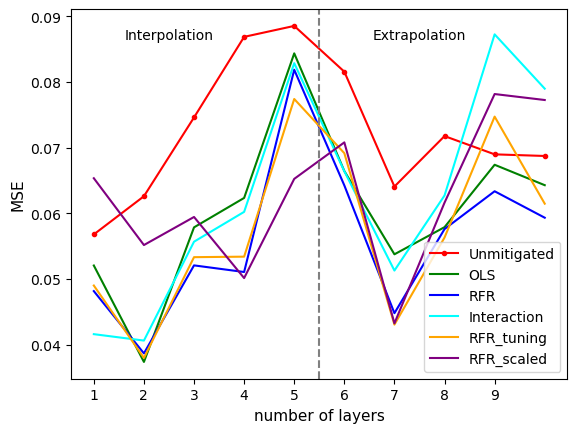

In [18]:
error_arr_unmi = []
error_arr_lr = []
error_arr_rf = []
error_arr_lri = []
error_arr_rf_hyper = []
error_arr_rf_scaled = []

x = range(1,11)

for j in x:
    # calculate errors for each number of layer
    y_cor_layers = y_eval_ipol['num_layers'] == j
    y_cor_layers_pred_lr = y_ipol_pred_lr[np.array(y_cor_layers)]
    y_cor_layers_pred_lri = y_ipol_pred_lri[np.array(y_cor_layers)]
    y_cor_layers_pred_rf = y_ipol_pred_rf[np.array(y_cor_layers)]
    y_cor_layers_pred_rf_hyper = y_ipol_pred_rf_hyper[np.array(y_cor_layers)]
    y_cor_layers_pred_rf_scaled = y_ipol_pred_rf_scaled[np.array(y_cor_layers)]
    y_cor_layers_target = y_eval_ipol[np.array(y_cor_layers)]['target']
    
    # calculate mean error of unmitigated model
    error_unmi = sum(np.abs(y_eval_ipol[np.array(y_cor_layers)]['noisy_expectation'] - y_cor_layers_target)**2)
    error_unmi /= y_cor_layers.sum()
    error_arr_unmi.append(error_unmi)
    
    # calculate mean error of LR model
    error = sum(np.abs(y_cor_layers_pred_lr - y_cor_layers_target)**2)
    error /= y_cor_layers.sum()
    error_arr_lr.append(error)

    # calculate mean error of LR model with interaction terms
    error = sum(np.abs(y_cor_layers_pred_lri - y_cor_layers_target)**2)
    error /= y_cor_layers.sum()
    error_arr_lri.append(error)

    # calculate mean error of RF model
    error = sum(np.abs(y_cor_layers_pred_rf - y_cor_layers_target)**2)
    error /= y_cor_layers.sum()
    error_arr_rf.append(error)

    # calculate mean error of RF model with hyperparameter tuning
    error = sum(np.abs(y_cor_layers_pred_rf_hyper - y_cor_layers_target)**2)
    error /= y_cor_layers.sum()
    error_arr_rf_hyper.append(error)

    # calculate mean error of RF model of scaled circuits
    error = sum(np.abs(y_cor_layers_pred_rf_scaled - y_cor_layers_target)**2)
    error /= y_cor_layers.sum()
    error_arr_rf_scaled.append(error)


plt.plot(x, error_arr_unmi, color='red', label = 'Unmitigated', marker='.')
plt.plot(x, error_arr_lr, color='green', label = 'OLS')
plt.plot(x, error_arr_rf, color='blue', label = 'RFR')
plt.plot(x, error_arr_lri, color='cyan', label = 'Interaction')
plt.plot(x, error_arr_rf_hyper, color='orange', label = 'RFR_tuning')
plt.plot(x, error_arr_rf_scaled, color='purple', label = 'RFR_scaled')
plt.legend(loc='lower right')
plt.axvline(x=5.5, color='gray', linestyle='--')

plt.text(2.5, plt.ylim()[1] * 0.95, 'Interpolation', horizontalalignment='center', fontsize=10)
plt.text(7.5, plt.ylim()[1] * 0.95, 'Extrapolation', horizontalalignment='center', fontsize=10)

plt.xticks(np.arange(1, 10, 1))

plt.xlabel('number of layers', fontsize=11)
plt.ylabel('MSE', fontsize=11)
#plt.title('Error extrapolation of models - increase number of layers')


C:\Users\malte\AppData\Local\Temp\ipykernel_6344\2073612062.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=90, ha='center', fontsize=14)


Text(0.5, 1.0, 'Error analysis extrapolation')

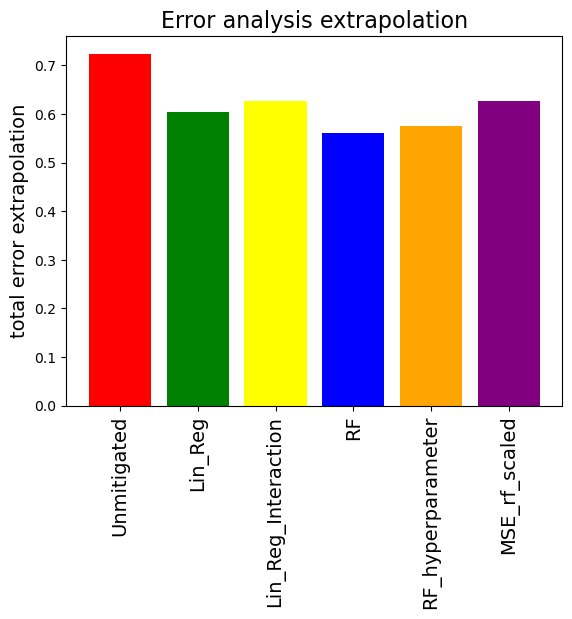

In [16]:
# plot total error in extrapolation

tot_error_unmi = sum(error_arr_unmi)
tot_error_lr = sum(error_arr_lr)
tot_error_lri = sum(error_arr_lri)
tot_error_rf = sum(error_arr_rf)
tot_error_rf_hyper = sum(error_arr_rf_hyper)
tot_error_rf_scaled = sum(error_arr_rf_scaled)

fig, ax = plt.subplots()

models = ['Unmitigated', 'Lin_Reg', 'Lin_Reg_Interaction', 'RF', 'RF_hyperparameter', 'MSE_rf_scaled']
tot_error =[tot_error_unmi, tot_error_lr, tot_error_lri, tot_error_rf, tot_error_rf_hyper, tot_error_rf_scaled]
colors = ['red', 'green', 'yellow', 'blue', 'orange', 'purple']

ax.bar(models, tot_error, color = colors)
ax.set_xticklabels(models, rotation=90, ha='center', fontsize=14)
ax.set_ylabel('total error extrapolation', fontsize=14)
ax.set_title('Error analysis extrapolation', fontsize=16)
